**Завдання 1**

Ми модифікуємо модель, щоб параметри були змінними у часі залежно від зовнішніх чинників.
$$ \begin{aligned} \alpha(t) &= f_\theta^{(\alpha)}(s(t), r(t)) \\ \beta(t) &= f_\theta^{(\beta)}(s(t), r(t)) \\ \gamma(t) &= f_\theta^{(\gamma)}(s(t), r(t)) \\ \delta(t) &= f_\theta^{(\delta)}(s(t), r(t)) \end{aligned}
$$
де: $s(t)$ — сезонність, $r(t)$ — доступність ресурсів, $f_\theta^{(\delta)}$ — нейронна мережа з параметрами $\theta$.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

# 1. Генерація зовнішніх факторів
def generate_external_factors(t_eval):
    seasonality = np.sin(2 * np.pi * t_eval / 12)
    resources = 0.5 + 0.5 * np.cos(2 * np.pi * t_eval / 6)
    return np.vstack([seasonality, resources]).T

def true_parameters(factors):
    s, r = factors[:, 0], factors[:, 1]
    alpha = 0.8 + 0.4 * s
    beta = 0.05 + 0.05 * r
    gamma = 1.2 + 0.3 * s
    delta = 0.04 + 0.05 * r
    return np.vstack([alpha, beta, gamma, delta]).T

# 2. Навчання нейромереж
from sklearn.neural_network import MLPRegressor

t_train = np.linspace(0, 24, 300)
X_train = generate_external_factors(t_train)
Y_train = true_parameters(X_train)

models = [MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000, random_state=1) for _ in range(4)]
for i in range(4):
    models[i].fit(X_train, Y_train[:, i])

def predict_parameters(factors):
    return np.column_stack([model.predict(factors) for model in models])

# 3. Гібридна модель
def lv_model(t, x, y):
    factors = generate_external_factors(np.array([t]))
    alpha, beta, gamma, delta = predict_parameters(factors)[0]
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

# 4. Реалізація інтеграції з виводом по ітераціях (RK4)
x0, y0 = 40.0, 9.0
t0, t_end = 0.0, 24.0
dt = 0.1
steps = int((t_end - t0) / dt)

t_values = [t0]
x_values = [x0]
y_values = [y0]

t = t0
x = x0
y = y0

print(f"{'Час':>5} | {'Жертви':>8} | {'Хижаки':>8}")
print("-" * 30)

for i in range(steps):
    dx1, dy1 = lv_model(t, x, y)
    dx2, dy2 = lv_model(t + dt/2, x + dx1*dt/2, y + dy1*dt/2)
    dx3, dy3 = lv_model(t + dt/2, x + dx2*dt/2, y + dy2*dt/2)
    dx4, dy4 = lv_model(t + dt, x + dx3*dt, y + dy3*dt)

    x += (dx1 + 2*dx2 + 2*dx3 + dx4) * dt / 6
    y += (dy1 + 2*dy2 + 2*dy3 + dy4) * dt / 6
    t += dt

    t_values.append(t)
    x_values.append(x)
    y_values.append(y)

    print(f"{t:5.2f} | {x:8.2f} | {y:8.2f}")


  Час |   Жертви |   Хижаки
------------------------------
 0.10 |    37.29 |    13.11
 0.20 |    33.30 |    17.58
 0.30 |    29.06 |    21.38
 0.40 |    25.46 |    23.79
 0.50 |    23.00 |    24.63
 0.60 |    21.59 |    24.31
 0.70 |    20.81 |    23.43
 0.80 |    20.34 |    22.38
 0.90 |    20.01 |    21.33
 1.00 |    19.85 |    20.27
 1.10 |    19.87 |    19.21
 1.20 |    19.88 |    18.35
 1.30 |    19.77 |    17.73
 1.40 |    19.55 |    17.30
 1.50 |    19.23 |    17.02
 1.60 |    18.81 |    16.85
 1.70 |    18.30 |    16.75
 1.80 |    17.80 |    16.59
 1.90 |    17.46 |    16.29
 2.00 |    17.32 |    15.83
 2.10 |    17.40 |    15.23
 2.20 |    17.69 |    14.55
 2.30 |    18.19 |    13.80
 2.40 |    18.94 |    12.98
 2.50 |    19.95 |    12.13
 2.60 |    21.22 |    11.28
 2.70 |    22.74 |    10.45
 2.80 |    24.53 |     9.67
 2.90 |    26.57 |     8.94
 3.00 |    28.88 |     8.29
 3.10 |    31.46 |     7.74
 3.20 |    34.29 |     7.29
 3.30 |    37.38 |     6.98
 3.40 |    40.70 

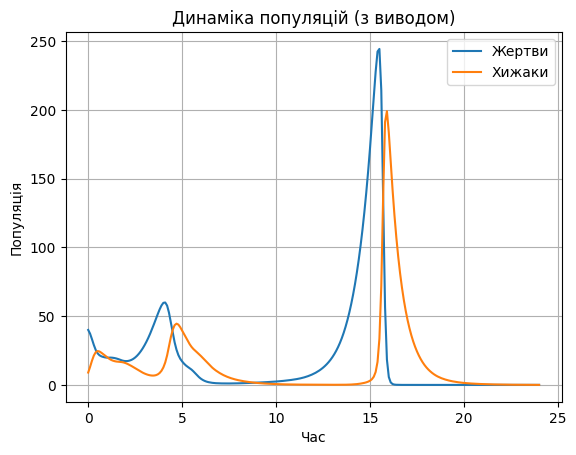

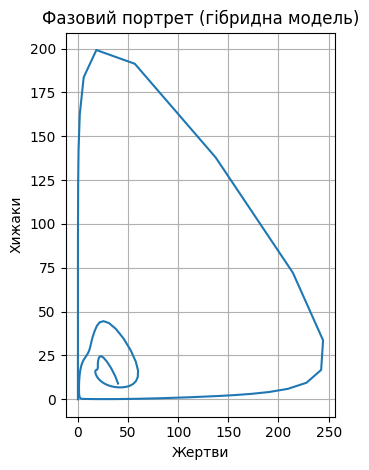

In [7]:
plt.plot(t_values, x_values, label="Жертви")
plt.plot(t_values, y_values, label="Хижаки")
plt.xlabel("Час")
plt.ylabel("Популяція")
plt.title("Динаміка популяцій (з виводом)")
plt.legend()
plt.grid(True)
plt.show()


plt.subplot(1, 2, 2)
plt.plot(x_values, y_values)
plt.title("Фазовий портрет (гібридна модель)")
plt.xlabel("Жертви")
plt.ylabel("Хижаки")
plt.grid(True)

plt.tight_layout()
plt.show()

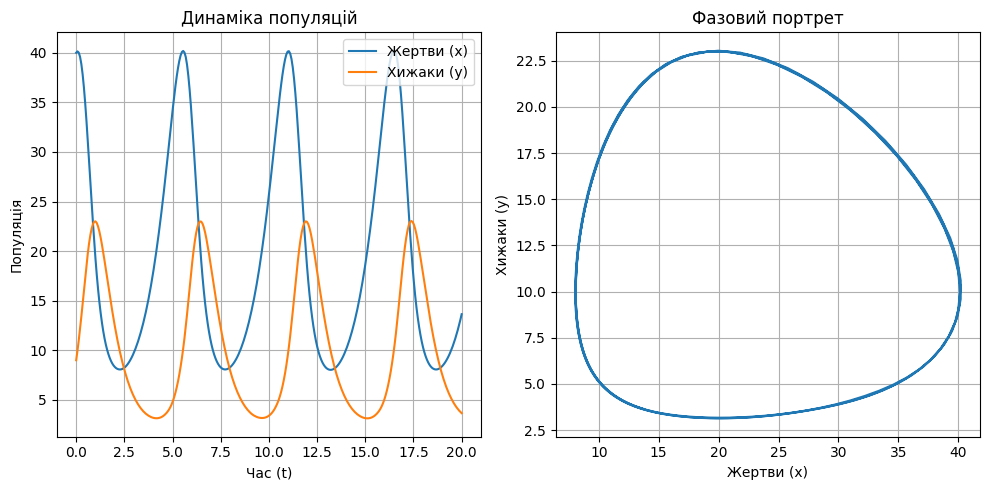

In [9]:
# 1. Імпорт необхідних бібліотек з типами
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# 2. Визначення параметрів моделі Лотка–Вольтера з типами
alpha: float = 1.0  # Коефіцієнт природного зростання жертв
beta: float = 0.1  # Коефіцієнт зменшення популяції жертв через хижацтво
delta: float = 0.075  # Коефіцієнт приросту хижаків завдяки споживанню жертв
gamma: float = 1.5  # Коефіцієнт природної смертності хижаків

# Початкові умови:
x0: float = 40.0  # Початкова чисельність жертв
y0: float = 9.0  # Початкова чисельність хижаків

# Проміжок часу, на якому вирішується система
t_span: tuple[float, float] = (0, 20)
t_eval: np.ndarray = np.linspace(t_span[0], t_span[1], 300)

# 3. Опис системи рівнянь Лотка–Вольтера з типізацією
def lotka_volterra_model(t: float, z: np.ndarray) -> np.ndarray:
    """
    Функція, що повертає похідні для системи рівнянь Лотка–Вольтера.

    Параметри:
    - t: поточний час (тип float)
    - z: масив, де z[0] — популяція жертв (x), z[1] — популяція хижаків (y)

    Повертає:
    - Масив похідних [dx/dt, dy/dt]
    """
    x, y = z  # Розпаковуємо популяції жертв та хижаків
    dxdt: float = alpha * x - beta * x * y
    dydt: float = delta * x * y - gamma * y
    return np.array([dxdt, dydt])

# 4. Чисельне розв'язання системи рівнянь за допомогою solve_ivp
solution = solve_ivp(lotka_volterra_model, t_span, [x0, y0], t_eval=t_eval)
# Пояснення:
# - lotka_volterra_model: функція, що описує систему рівнянь.
# - t_span: інтервал часу, на якому обчислюється розв'язок.
# - [x0, y0]: початкові значення для популяцій жертв та хижаків.
# - t_eval: моменти часу, в яких обчислюється розв'язок.

# 5. Побудова графіків чисельного розв'язання
plt.figure(figsize=(10, 5))

# Графік залежності популяцій від часу
plt.subplot(1, 2, 1)
plt.plot(solution.t, solution.y[0], label="Жертви (x)")
plt.plot(solution.t, solution.y[1], label="Хижаки (y)")
plt.xlabel("Час (t)")
plt.ylabel("Популяція")
plt.title("Динаміка популяцій")
plt.legend()
plt.grid(True)

# Фазовий портрет (залежність популяції хижаків від популяції жертв)
plt.subplot(1, 2, 2)
plt.plot(solution.y[0], solution.y[1])
plt.xlabel("Жертви (x)")
plt.ylabel("Хижаки (y)")
plt.title("Фазовий портрет")
plt.grid(True)

plt.tight_layout()
plt.show()
# Пояснення:
# Лівий графік показує, як змінюються популяції жертв та хижаків у часі.
# Правий графік (фазовий портрет) демонструє взаємозв'язок між популяціями.

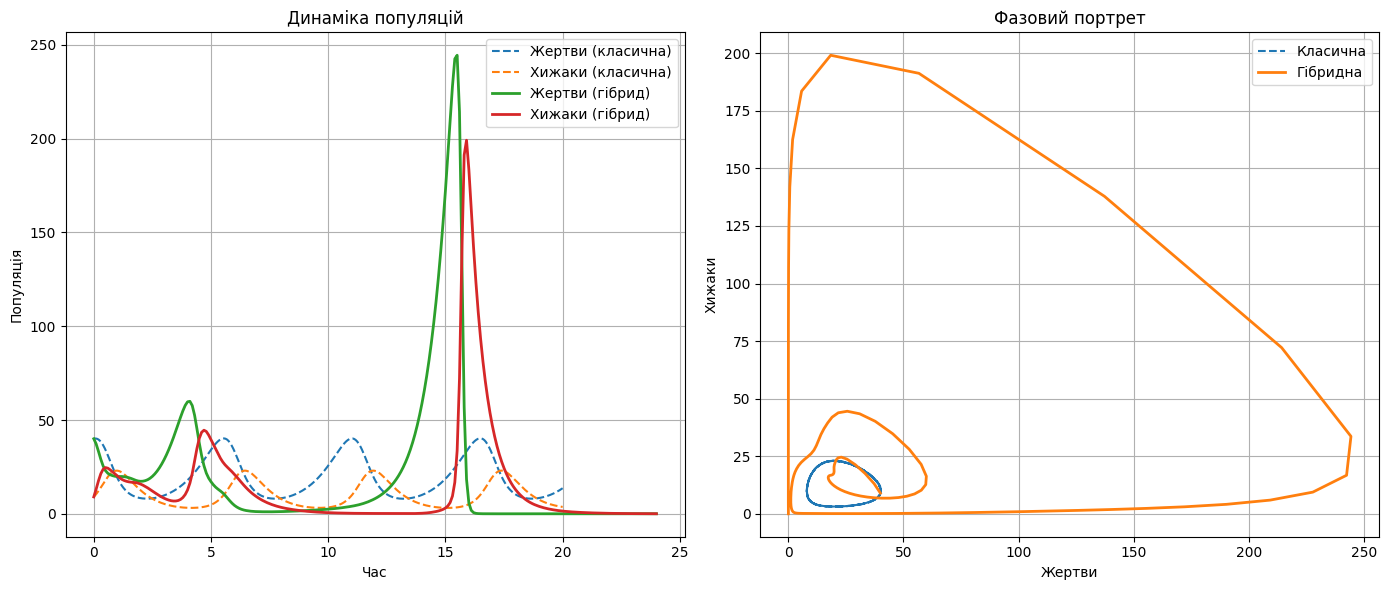

In [10]:
plt.figure(figsize=(14, 6))

# Динаміка популяцій
plt.subplot(1, 2, 1)
plt.plot(solution.t, solution.y[0], label="Жертви (класична)", linestyle="--")
plt.plot(solution.t, solution.y[1], label="Хижаки (класична)", linestyle="--")
plt.plot(t_values, x_values, label="Жертви (гібрид)", linewidth=2)
plt.plot(t_values, y_values, label="Хижаки (гібрид)", linewidth=2)
plt.title("Динаміка популяцій")
plt.xlabel("Час")
plt.ylabel("Популяція")
plt.legend()
plt.grid(True)

# Фазовий портрет
plt.subplot(1, 2, 2)
plt.plot(solution.y[0], solution.y[1], label="Класична", linestyle="--")
plt.plot(x_values, y_values, label="Гібридна", linewidth=2)
plt.title("Фазовий портрет")
plt.xlabel("Жертви")
plt.ylabel("Хижаки")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Завдання 2**

1. Візьмемо фінансові часові ряди

2. Побудуємо LSTM-модель для прогнозування:

3. майбутньої доходності

4. майбутньої волатильності

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [12]:
# Завантаження даних
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')

# Вибір лише стовпця 'Close' для аналізу
data = data[['Close']]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


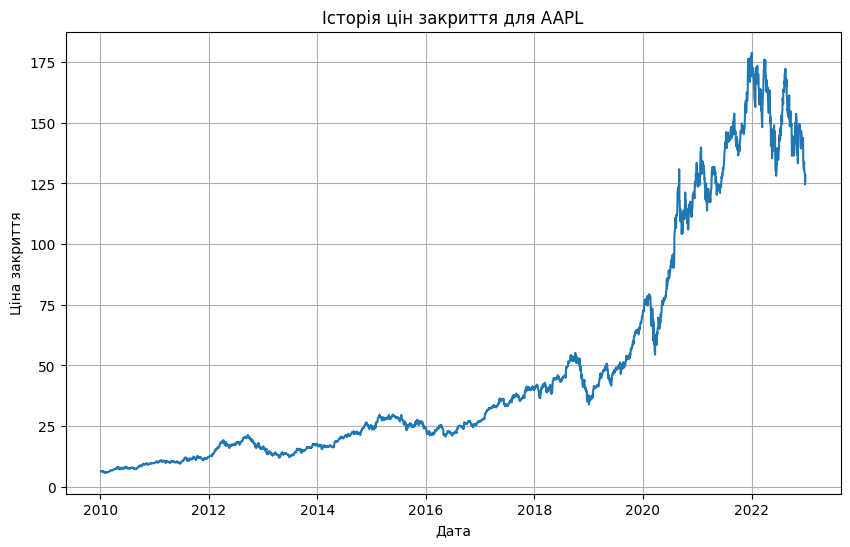

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'])
plt.title(f'Історія цін закриття для {ticker}')
plt.xlabel('Дата')
plt.ylabel('Ціна закриття')
plt.grid(True)
plt.show()

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [15]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

Оптимізація портфеля за моделлю Марковіца: $$ \begin{aligned} &\min_{w} \quad w^T \Sigma w \\ &\text{за умови: } \\ &\quad w^T \mu = R_{\text{target}}, \\ &\quad \sum_{i=1}^{n} w_i = 1 \end{aligned} $$ де: $w$ — вектор ваг активів, $ \Sigma$ — коваріаційна матриця ризиків, $\mu$ — вектор очікуваної доходності,  $R_{\text{target}}$ — цільова доходність. Використовуємо прогнозовані: $\hat{r}_t$ — доходність, $ \hat{\sigma}_t $ — волатильність. Оптимізаційне правило: $$ w_i \propto \frac{\hat{r}_i}{\hat{\sigma}_i} $$ Після нормалізації: $$ w_i = \frac{\frac{\hat{r}_i}{\hat{\sigma}_i}}{\sum_{j=1}^{n} \frac{\hat{r}_j}{\hat{\sigma}_j}} $$ де $w_i$ — вага активу $i$ в портфелі.

In [16]:
seq_length = 60  # Наприклад, використовуємо 60 днів для прогнозу наступного дня

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - seq_length:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [17]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 3.0762e-04 - val_loss: 0.0012
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - loss: 2.5209e-04 - val_loss: 0.0011
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 2.2501e-04 - val_loss: 0.0012
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 2.4889e-04 - val_loss: 0.0012
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 2.0893e-04 - val_loss: 9.9876e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 1.8868e-04 - val_loss: 0.0015
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.8712e-04 - val_loss: 0.0022
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 1.8282e-04 - val_loss: 0.0016
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 1.7418e-04 - val_loss: 0.0017
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 1.5509e-04 - val_loss: 0.0033
Epoch 12/20
8

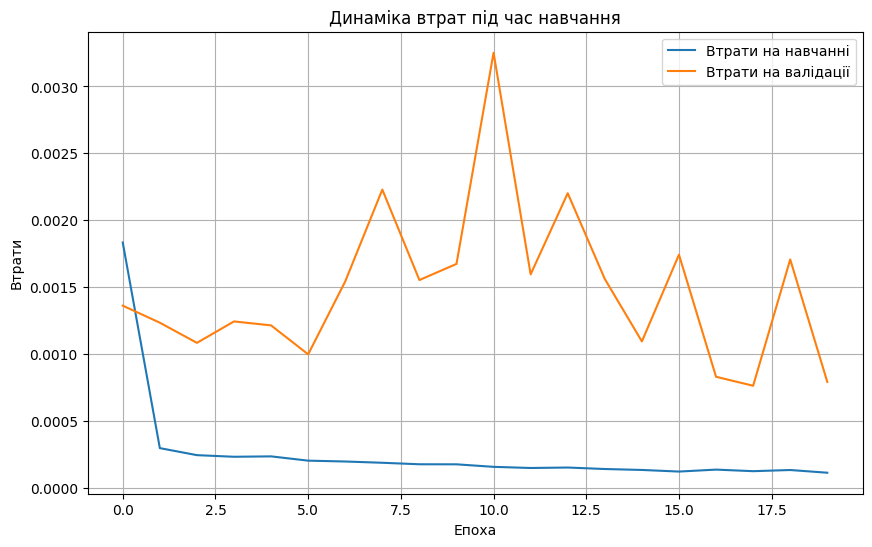

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Втрати на навчанні')
plt.plot(history.history['val_loss'], label='Втрати на валідації')
plt.title('Динаміка втрат під час навчання')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


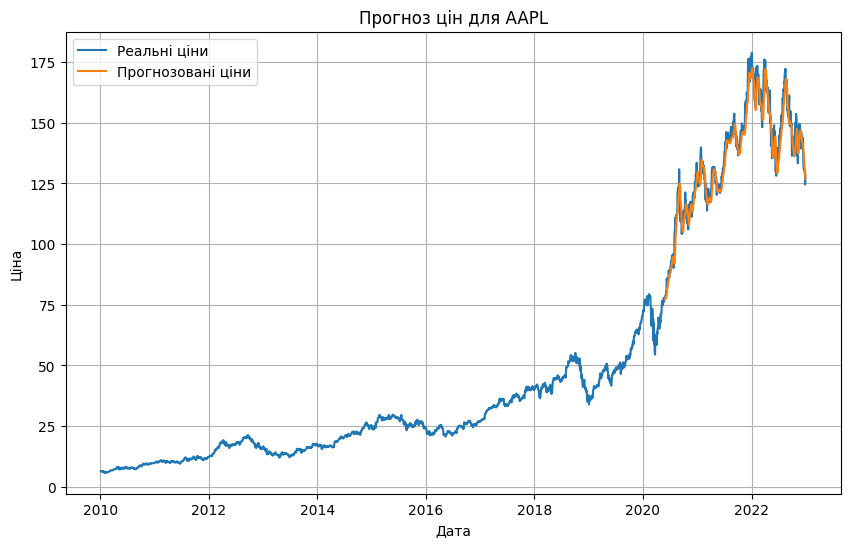

In [22]:
# Обчислюємо правильні індекси для прогнозованих цін
predicted_index = data.index[-len(predicted_prices):]

# Побудова графіку
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Реальні ціни')
plt.plot(predicted_index, predicted_prices, label='Прогнозовані ціни')
plt.title(f'Прогноз цін для {ticker}')
plt.xlabel('Дата')
plt.ylabel('Ціна')
plt.legend()
plt.grid(True)
plt.show()
